# Introduction to Weight Quantization
> Reducing the size of Large Language Models with 8-bit quantization

Companion notebook to execute the code from the following article: https://mlabonne.github.io/blog/intro_weight_quantization/

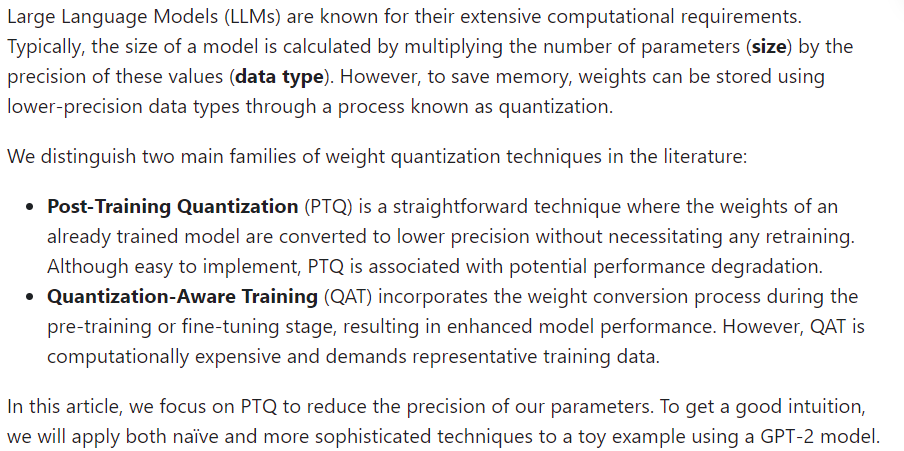

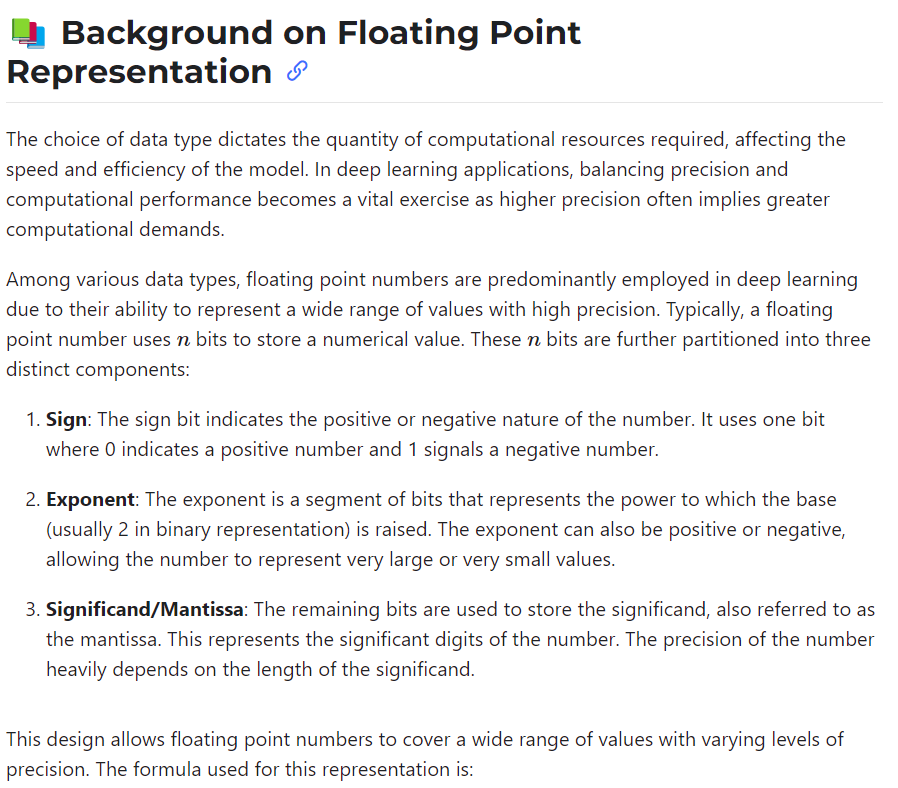

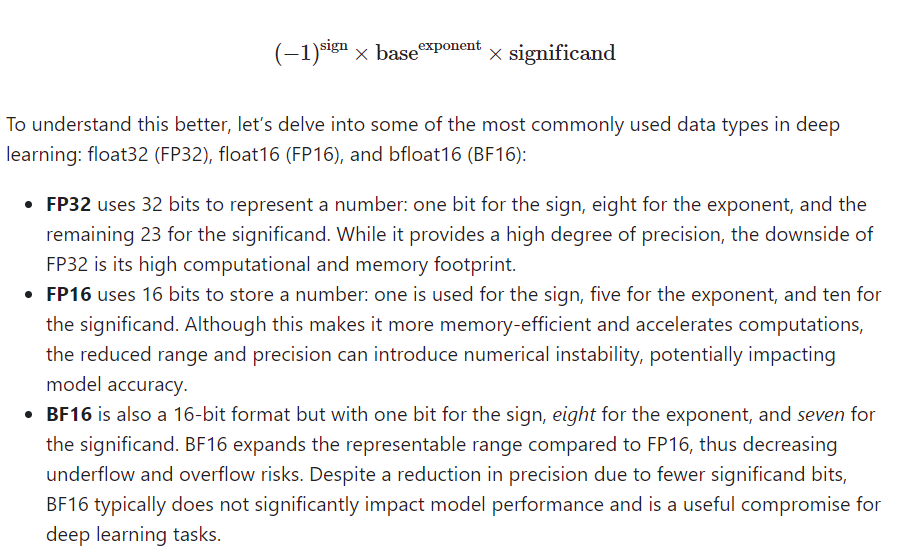

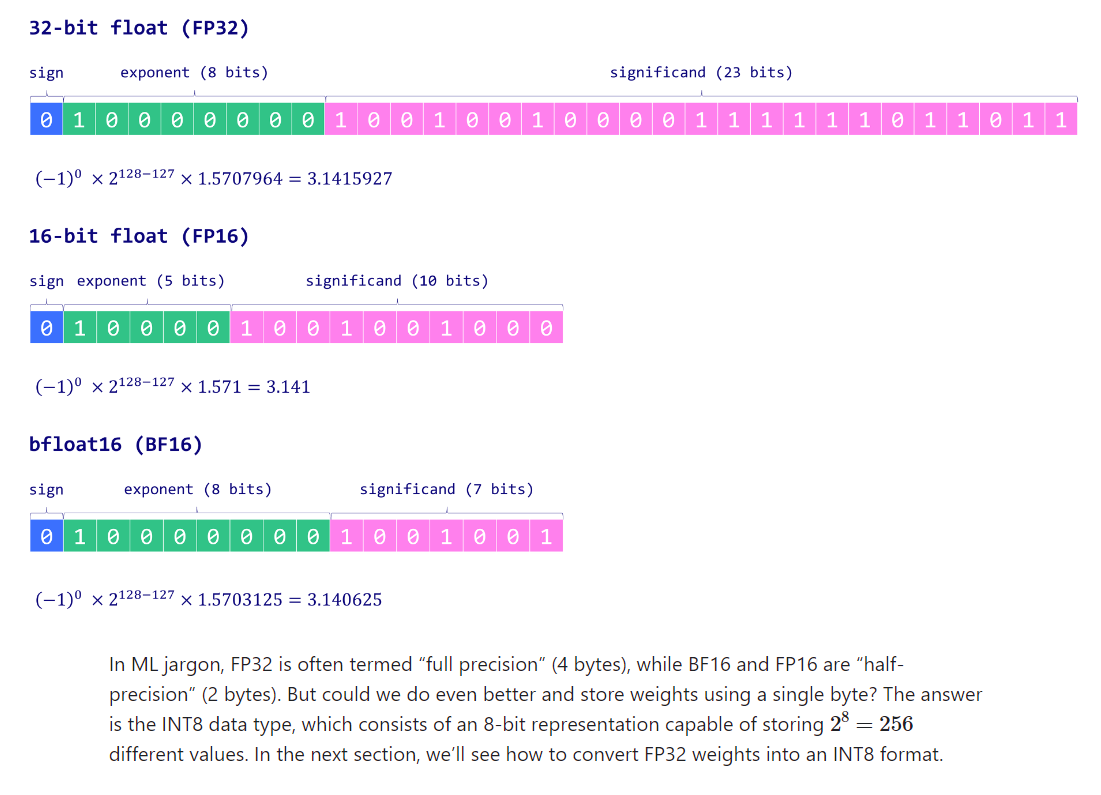

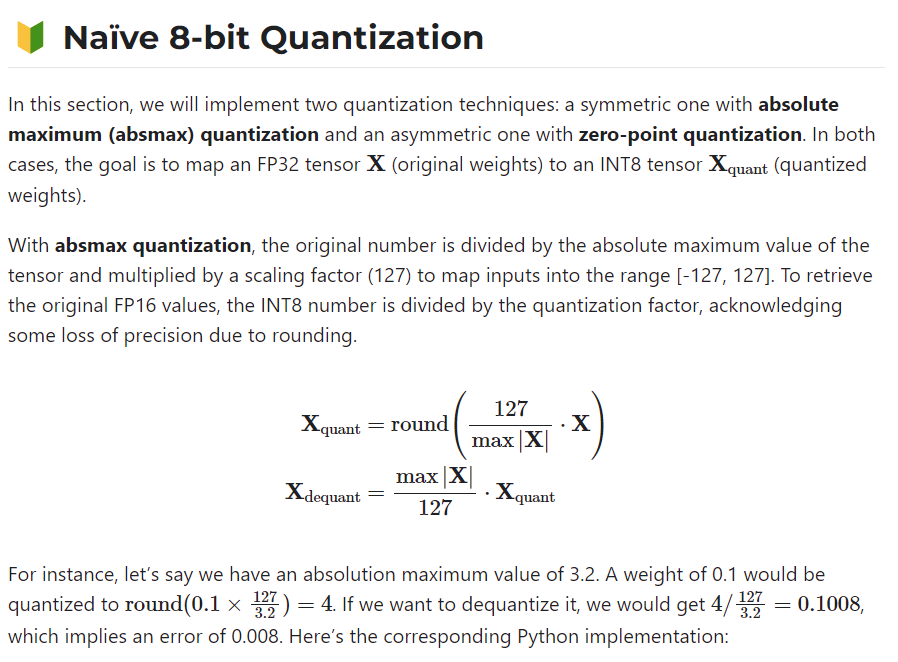

In [1]:
import torch

def absmax_quantize(X):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

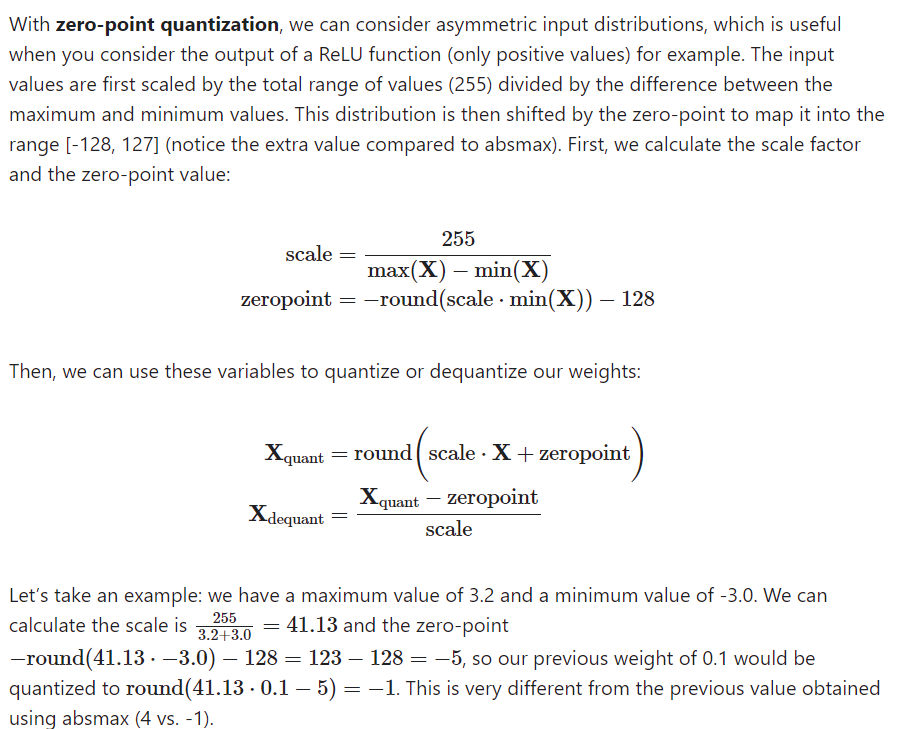

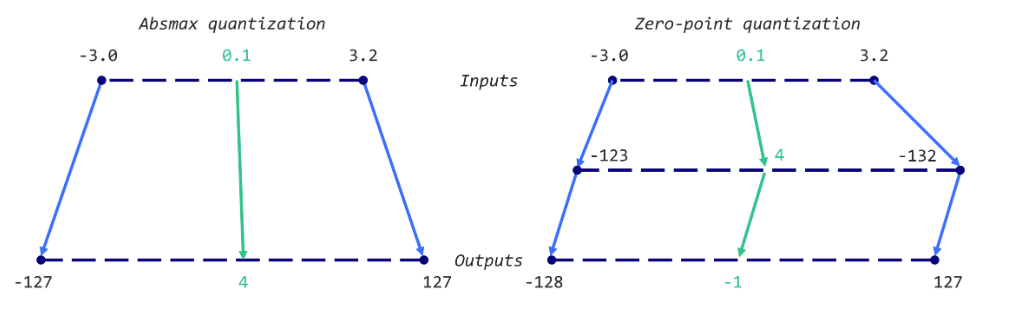

In [2]:
def zeropoint_quantize(X):
    # Calculate value range (denominator)
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range

    # Calculate scale
    scale = 255 / x_range

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()

    # Scale and round the inputs
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    # Dequantize
    X_dequant = (X_quant - zeropoint) / scale

    return X_quant.to(torch.int8), X_dequant

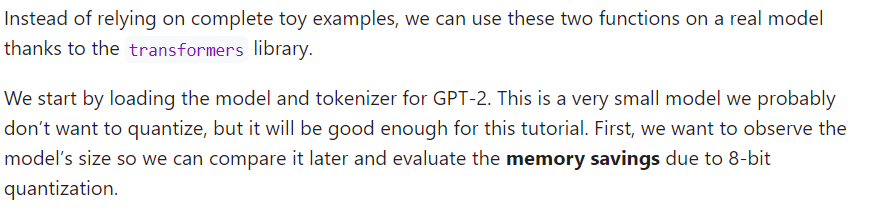

In [3]:
!pip install -q bitsandbytes>=0.39.0
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
torch.manual_seed(0)

# Set device to CPU for now
device = 'cpu'

# Load model and tokenizer
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Print model size
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


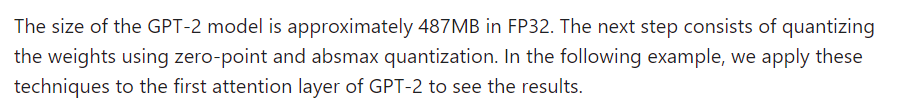

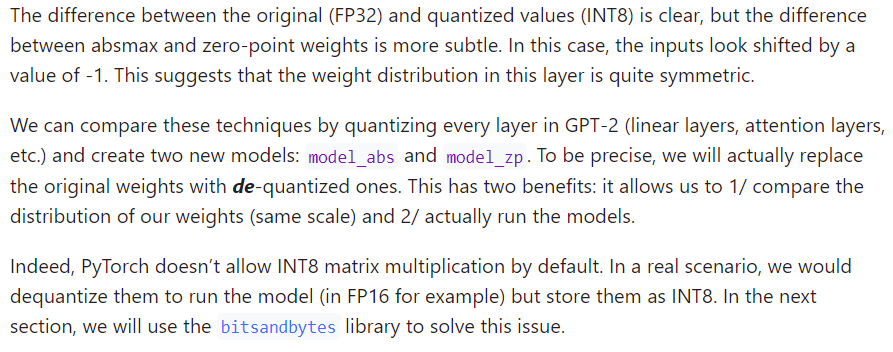

In [5]:
# Extract weights of the first layer
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

# Quantize layer using absmax quantization
weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

# Quantize layer using absmax quantization
weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]])

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], dtype=torch.int8)

Zero-point quantized weights:
tensor([[-20, -11,  -3,  ...,   3,  -2,   2],
        [  5,   8,  12,  ...,  -1,   0,   0],
        [  1,   4,  18,  ...,   6,   3,   0],
        ...,
        [-11,   0,  10,  ...,  

In [6]:
import numpy as np
from copy import deepcopy

# Store original weights
weights = [param.data.clone() for param in model.parameters()]

# Create model to quantize
model_abs = deepcopy(model)

# Quantize all model weights
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

# Create model to quantize
model_zp = deepcopy(model)

# Quantize all model weights
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

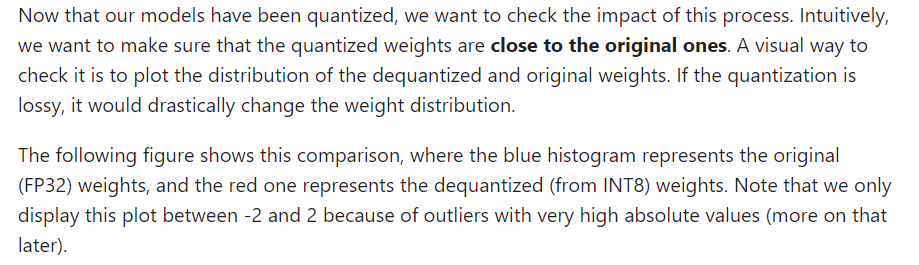

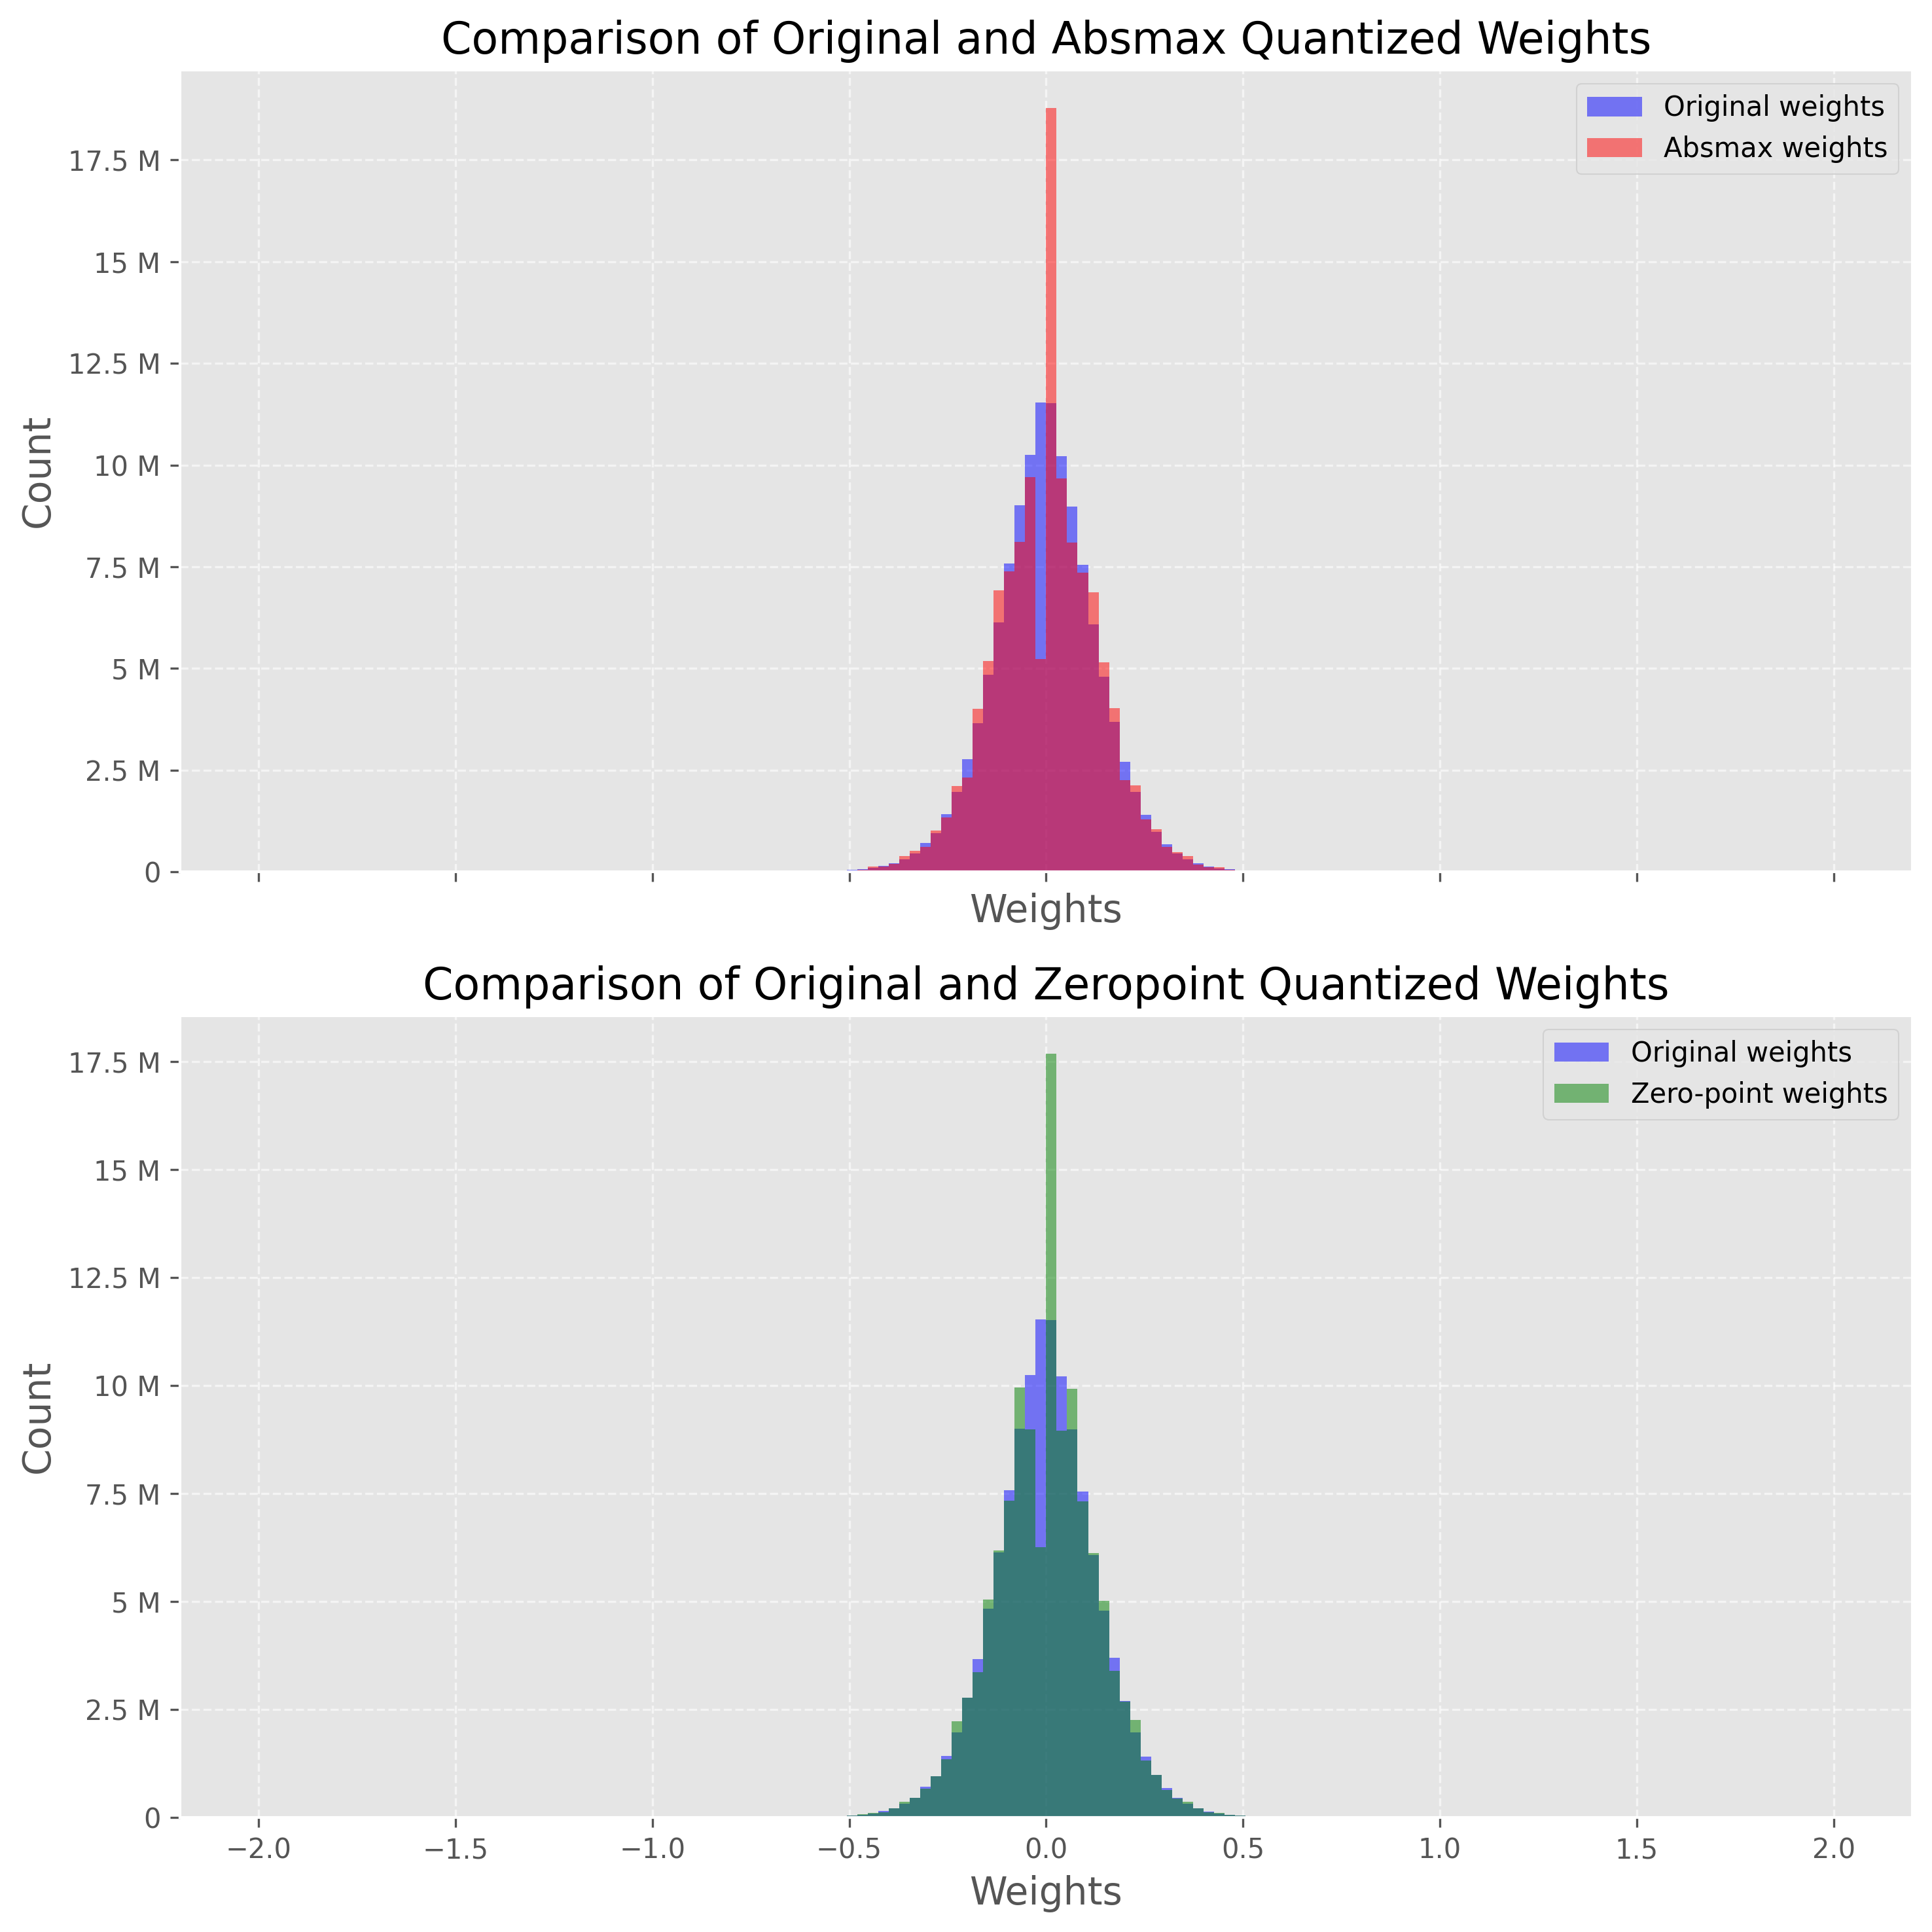

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()


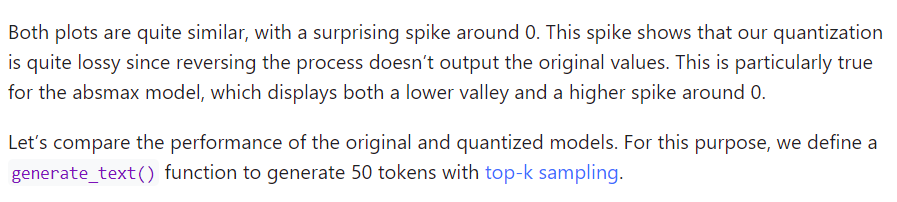

In [8]:
def generate_text(model, input_text, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate text with original and quantized models
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream," he said. "You have a dream. The dream of a great guy. You dream that you'll be one day an NFL superstar. You dream that you'll be one day a quarterback in the NFL. You dream that
--------------------------------------------------
Absmax model:
I have a dream on my hands, to have all of America become better off." It's only a dream, but it's worth it. This was an awesome time to be alive! I was really, really lucky here, I could have been
--------------------------------------------------
Zeropoint model:
I have a dream for you. We both love you.


Thank You!

I love you,

you're the coolest.


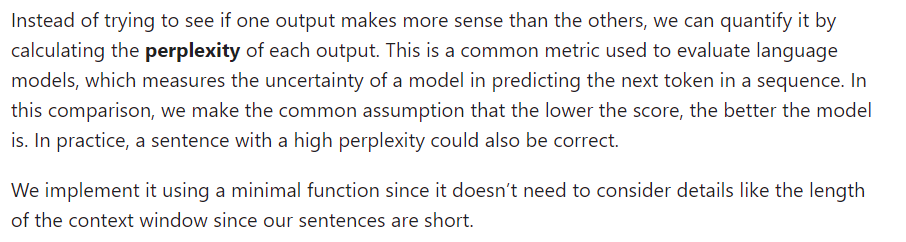

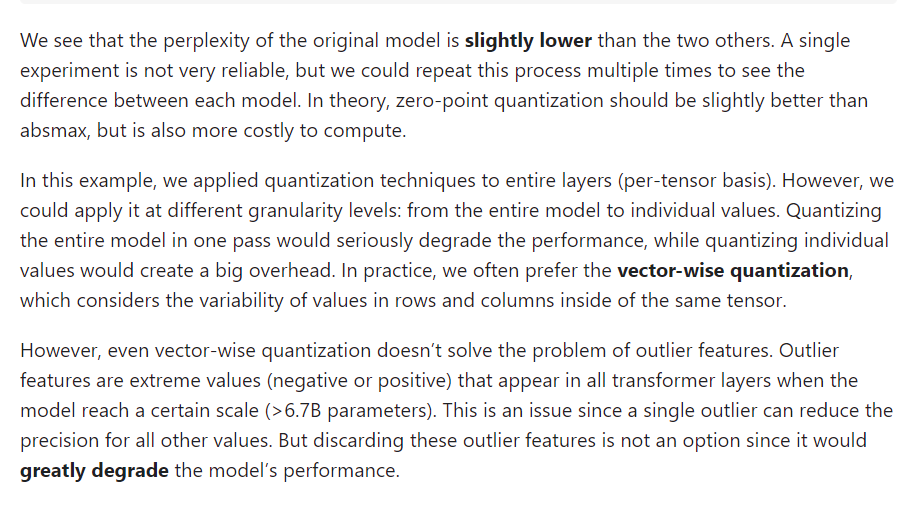

In [9]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)

    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Loss calculation
    neg_log_likelihood = outputs.loss

    # Perplexity calculation
    ppl = torch.exp(neg_log_likelihood)

    return ppl

ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity: {ppl.item():.2f}")
print(f"Absmax perplexity:   {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity: 7.59
Absmax perplexity:   21.52
Zeropoint perplexity: 18.08


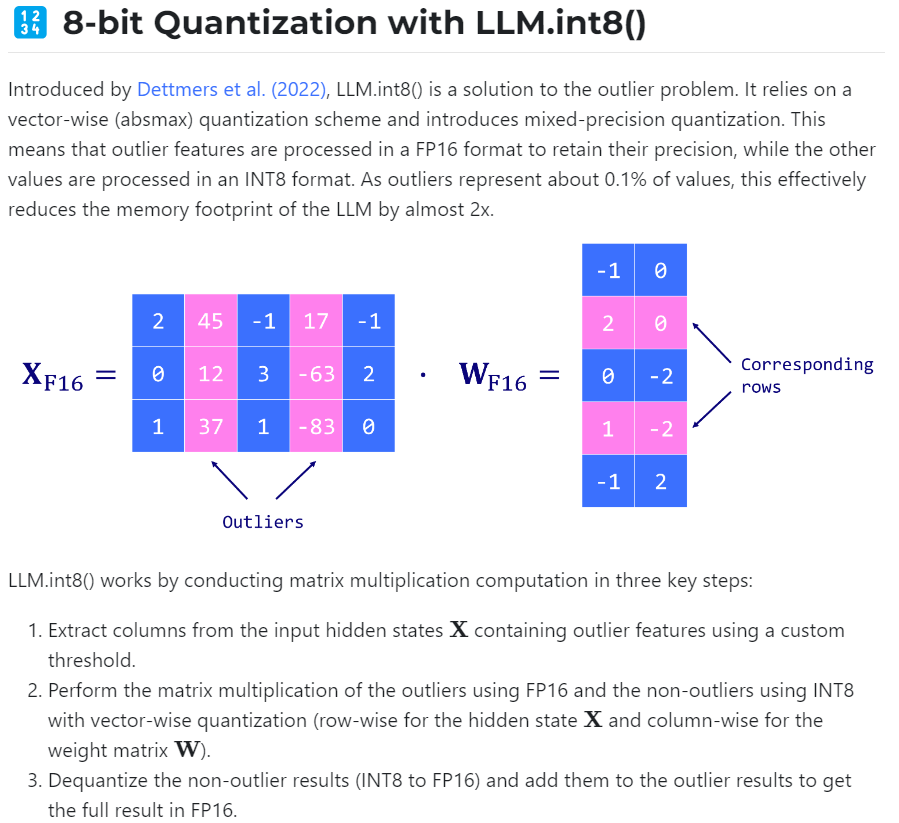

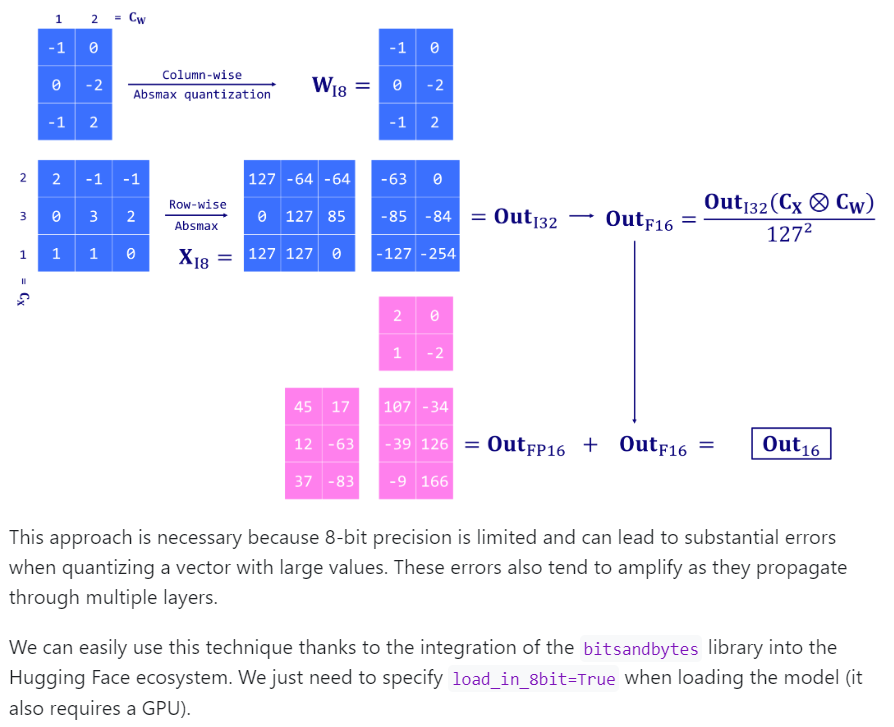

With this extra line of code, the model is now almost three times smaller (168MB vs. 487MB). We can even compare the distribution of the original and quantized weights as we did earlier:



In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_int8 = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='auto',
                                             load_in_8bit=True,
                                             )
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Model size: 176,527,896 bytes


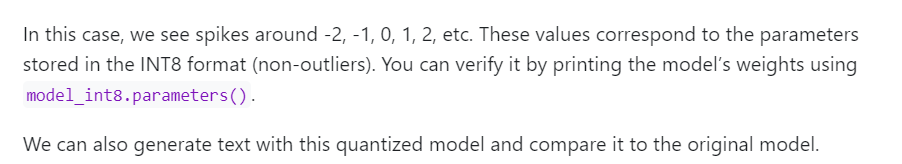

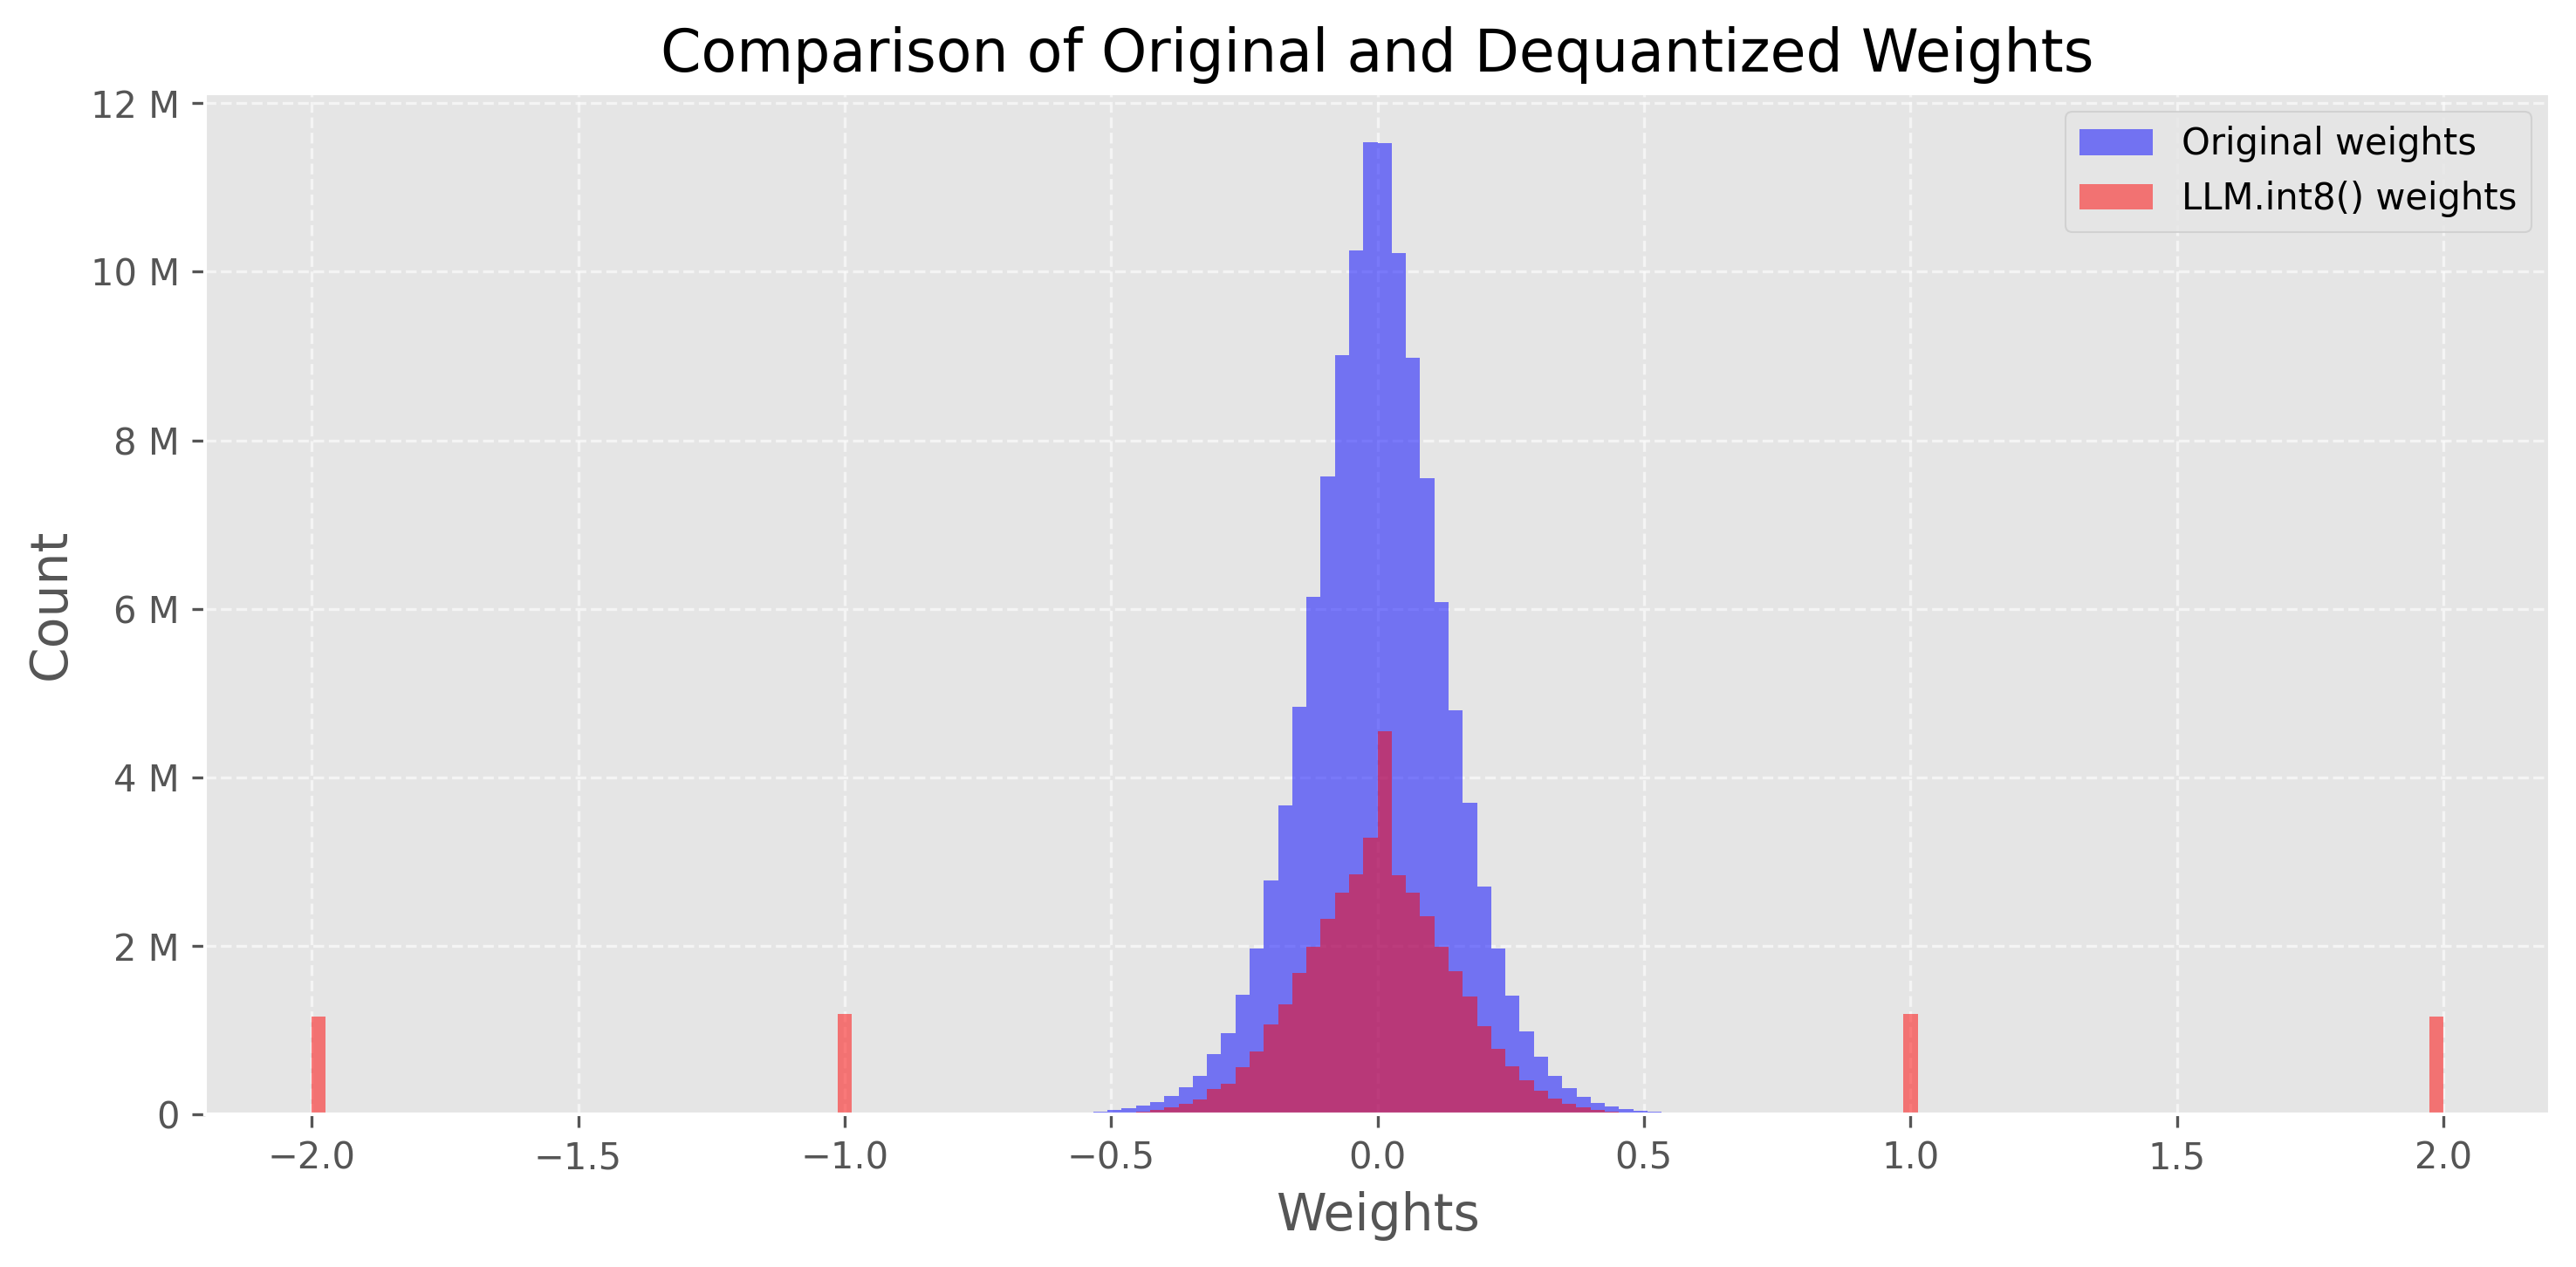

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = np.concatenate([t.cpu().numpy().flatten() for t in weights_int8])

# Set background style
plt.style.use('ggplot')

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,5), dpi=300)

# Plot the histograms
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))

# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
ax.legend()

# Add title and labels
ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())

# Improve font
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

In [12]:
# Generate text with quantized model
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

Original model:
I have a dream," he said. "You have a dream. The dream of a great guy. You dream that you'll be one day an NFL superstar. You dream that you'll be one day a quarterback in the NFL. You dream that
--------------------------------------------------
LLM.int8() model:
I have a dream. I don't know what will come of it, but I am going to have to look for something that will be right. I haven't thought about it for a long time, but I have to try to get that thing


Once again, it is difficult to judge what is the best output, but we can rely on the perplexity metric to give us an (approximate) answer.



In [13]:
print(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")

Perplexity (original):   7.59
Perplexity (LLM.int8()): 7.87


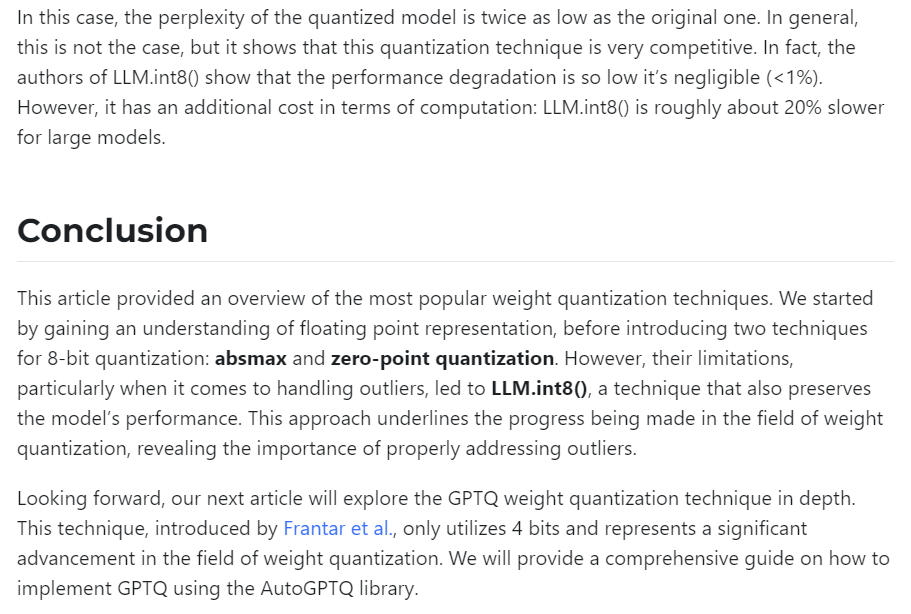

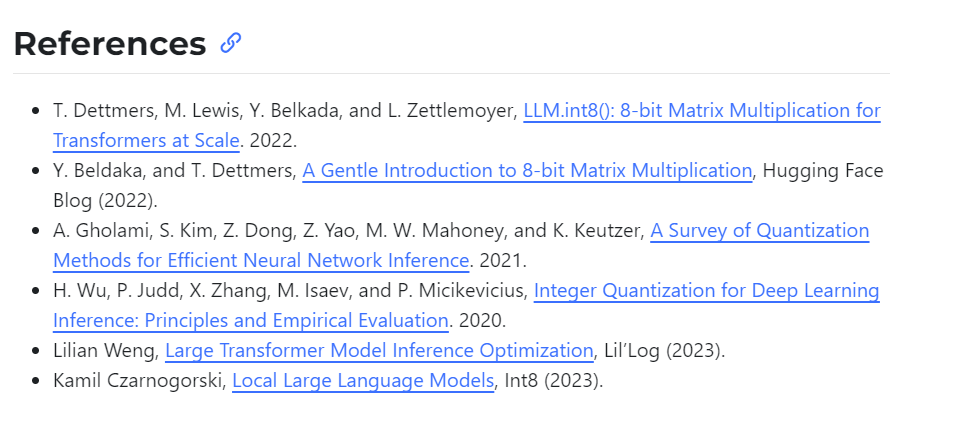